# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations

asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['CAN', 'BUY', 'LEAVE', 'GET', 'GROUP', 'SELF', 'ANN', 'BUY1', 'BOX', 'WRITE', 'WILL', 'HERE', 'VEGETABLE', 'SUE', 'THROW', 'SOMETHING-ONE', 'TELL', 'FIND', 'WOMAN', 'POTATO', 'FRANK', 'JANA', 'OLD', 'CORN', 'CHICAGO', 'SELL', 'BROTHER', 'WHO', 'CHINA', 'GO2', 'GIVE', 'WONT', 'GIVE3', 'BREAK-DOWN', 'LAST-WEEK', 'LIKE', 'HAVE', 'DECIDE', 'LOVE', 'IX-1P', 'MARY', 'FUTURE', 'JOHN', 'PAST', 'ALL', 'TOY', 'EAT', 'GO1', 'SEE', 'MAN', 'SAY', 'POSS', 'NEW', 'PARTY', 'PEOPLE', 'GIRL', 'SAY-1P', 'PREFER', 'KNOW', 'MOTHER', 'BLAME', 'GO', 'READ', 'MOVIE', 'BORROW', 'BILL', 'HOMEWORK', 'LEG', 'BOOK', 'LIVE', 'TEACHER', 'ARRIVE', 'IX', 'GIVE2', 'THINK', 'WHAT', 'NEW-YORK', 'YESTERDAY', 'STUDENT', 'COAT', 'SEARCH-FOR', 'BUT', 'FRIEND', 'CHICKEN', 'VISIT', 'VIDEOTAPE', 'CANDY', 'NAME', 'TOMORROW', 'FRED', 'NOT', 'HIT', 'HOUSE', 'CHOCOLATE', 'TOY1', 'GIVE1', 'BROCCOLI', 'BOY', 'STOLEN', 'WANT', 'MANY', 'SHOOT', 'SHOULD', 'FUTURE1', 'FINISH', 'APPLE', 'PUTASIDE', 'FISH', 'CORN1', 'BLUE'

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# Created a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# added features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_pos = ['right-x', 'right-y', 'left-x', 'left-y']

for feature, root_feat in zip(features_norm, features_pos):
    root_feat_mean = asl.df['speaker'].map(df_means[root_feat])
    root_feat_std = asl.df['speaker'].map(df_std[root_feat])
    asl.df[feature] = (asl.df[root_feat] - root_feat_mean) / root_feat_std


In [12]:
# added features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

grnd_rx, grnd_ry = asl.df['grnd-rx'], asl.df['grnd-ry']
grnd_lx, grnd_ly = asl.df['grnd-lx'], asl.df['grnd-ly']

asl.df['polar-rr'] = np.hypot(grnd_rx, grnd_ry)
asl.df['polar-lr'] = np.hypot(grnd_lx, grnd_ly)
asl.df['polar-rtheta'] = np.arctan2(grnd_rx, grnd_ry)
asl.df['polar-ltheta'] = np.arctan2(grnd_lx, grnd_ly)

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [13]:
# added features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df['right-x'].fillna(0).diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].fillna(0).diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].fillna(0).diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].fillna(0).diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [14]:
# added features of own design, which may be a combination of the above or something else

# Normalize Grounded Features
features_norm_grnd = ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx','norm-grnd-ly']
features_grnd = ['grnd-rx', 'grnd-ry', 'grnd-lx','grnd-ly']

df_std = asl.df.groupby('speaker').std()
df_mean = asl.df.groupby('speaker').mean()

for feature, root_feat in zip(features_norm_grnd, features_grnd):
    asl.df[feature] = (asl.df[root_feat] - asl.df['speaker'].map(df_means[root_feat])) / asl.df['speaker'].map(df_std[root_feat])

# Delta Values for Normalized Grounded Features
features_delta_norm_grnd = ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']
asl.df[features_delta_norm_grnd] = asl.df[features_norm_grnd].fillna(0).diff().fillna(0)

# define a list named 'features_custom' for building the training set
features_custom = features_norm_grnd + features_delta_norm_grnd + features_polar

## Question 1
What custom features did you choose for the features_custom set and why?

**Answer 1:**

I normalized the features with respect to nose-coordinates (`features_norm_grnd`) and also created delta features for the same (`features_delta_norm_grnd`). I chose the same with the hypothesis that normalized grounded features would be immune to speaker's height and thus provide a better model (the hypothesis is supported by the results presented below). From the lecture, the advantage of using delta features was also apparent, and hence I applied delta to normalized grounded features also.

I also used polar co-ordinates of the features (`features_polar`) after emperically trying out various features. The polar features had better WER than any other features (same can be seen the results presented below).  

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.018s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.11387810466


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12394796  69.44049919  17.02801704  77.7205691 ]
variance =  [ 19.70674528  16.82815886  30.51697671  11.06353197]

hidden state #1
mean =  [ -11.45302513   94.10892801   19.03509197  102.20264142]
variance =  [  77.40229281  203.35476019   26.68860173  156.13023448]

hidden state #2
mean =  [ -3.46515228  50.66596842  14.02390826  52.04643498]
variance =  [ 49.12360715  43.03693027  39.35198275  47.23170199]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

###### Features Ground

In [18]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -5.40610712  60.1670934    2.3235506   91.31297307]
variance =  [   7.95231495   64.13484213   13.67865937  129.57731141]

hidden state #1
mean =  [ -9.29971059  55.32230113   6.92262016  71.2442641 ]
variance =  [ 16.17313757  46.48900015   3.8119726   15.82255467]

hidden state #2
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

logL = -601.3291731989655


###### Normalized Features Ground

In [19]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_norm_grnd) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 1.06412238 -0.03233293 -1.22603529 -1.39310193]
variance =  [ 0.04691721  0.00453018  0.04815936  0.06657769]

hidden state #1
mean =  [ 0.34506594  0.02293868 -0.14000614 -0.61293176]
variance =  [ 0.04095569  0.05472649  0.07361128  0.16367441]

hidden state #2
mean =  [ 0.33374101 -0.23279631 -0.44681517 -1.66052162]
variance =  [ 0.03597639  0.00450417  0.00154608  0.00647978]

logL = 48.3067166104885


###### Delta of Normalized Features Ground

In [20]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_delta_norm_grnd) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [  5.16122477e-11   4.32876893e-03   3.87530567e-20   4.12567923e-20]
variance =  [ 0.00050064  0.00086416  0.00050064  0.00050064]

hidden state #1
mean =  [ 0.12726381 -0.00349249 -0.04894013 -0.31702206]
variance =  [ 0.02509041  0.00398245  0.0331499   0.01393725]

hidden state #2
mean =  [-0.04374835  0.08372573  0.06363366  0.06766335]
variance =  [ 0.0681338   0.01271818  0.03756954  0.01724107]

logL = 247.6297809555257


###### Polar Features

In [21]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [  8.81313612e+01   8.31771967e-03   1.09304329e+02   1.18434797e-01]
variance =  [  2.06973439e+01   5.41190376e-03   1.41647879e+02   1.92144403e-03]

hidden state #1
mean =  [ 56.18512764  -0.16336597  71.62607112   0.09580624]
variance =  [  5.15658455e+01   4.22949047e-03   1.76678004e+01   1.18132535e-03]

hidden state #2
mean =  [  6.05093955e+01  -9.31657523e-02   9.14269996e+01   2.56662599e-02]
variance =  [  6.15467240e+01   3.56796237e-03   1.30633638e+02   1.81801246e-03]

logL = -179.20709865685717


###### Custom Features

In [22]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [  9.94163854e-01  -1.51765543e-02  -1.22453620e+00  -1.32713153e+00
   1.15118143e-01  -2.80436736e-02  -3.50808698e-33  -8.65854150e-02
   8.81313612e+01   8.31771967e-03   1.09304329e+02   1.18434797e-01]
variance =  [  9.67595591e-02   7.38463628e-03   4.41641100e-02   1.08803085e-01
   5.12727796e-02   4.82382686e-03   3.30794927e-02   3.27113038e-02
   2.06973439e+01   5.41190376e-03   1.41647879e+02   1.92144403e-03]

hidden state #1
mean =  [  2.76077735e-01   2.74052681e-02  -1.72065407e-01  -1.10841451e+00
  -3.89666211e-02   4.75528048e-02   1.23257118e-02   3.59790686e-02
   6.20370912e+01  -1.30815548e-01   7.89384224e+01   5.59139670e-02]
variance =  [  3.47865924e-02   5.60745495e-02   5.58949247e-02   2.19455447e-01
   2.88248462e-02   8.12207965e-03   1.84012850e-02   6.82446264e-03
   6.36505183e+01   4.13679294e-03   5.87089019e+01   2.39833832e-03]

hidden state #2
mean =  [  4.67234436e-01

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [23]:
%matplotlib inline

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.29971059  55.32230113   6.92262016  71.2442641 ]
variance =  [ 16.17313757  46.48900015   3.8119726   15.82255467]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40610712  60.1670934    2.3235506   91.31297307]
variance =  [   7.95231495   64.13484213   13.67865937  129.57731141]

logL = -601.3291731989652


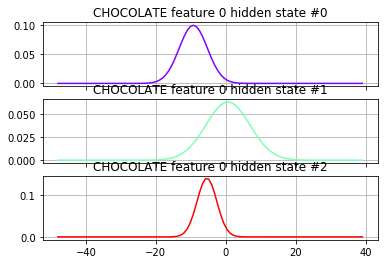

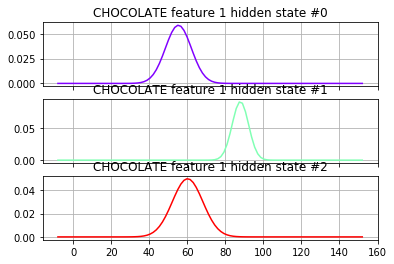

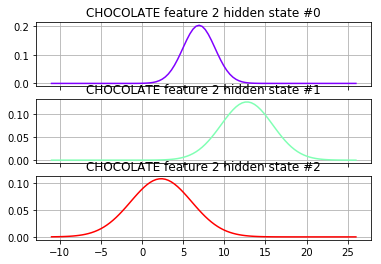

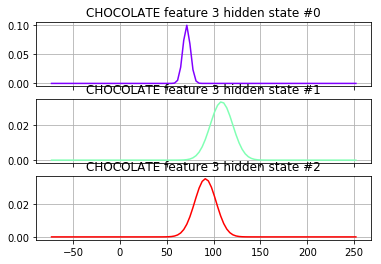

In [24]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [25]:
from my_model_selectors import SelectorConstant

# Experimenting with different feature sets and words
for features in [features_ground, features_norm_grnd, features_delta_norm_grnd, features_polar]:
    print("For Features: {}".format(', '.join(features)))
    for word in ['VEGETABLE', 'BOOK', 'FUTURE']:
        training = asl.build_training(features)
        model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
        print("\tNumber of states trained in model for {} is {}".format(word, model.n_components))
    print("")

For Features: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for FUTURE is 3

For Features: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for FUTURE is 3

For Features: delta-norm-grnd-rx, delta-norm-grnd-ry, delta-norm-grnd-lx, delta-norm-grnd-ly
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for FUTURE is 3

For Features: polar-rr, polar-rtheta, polar-lr, polar-ltheta
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for FUTURE is 3



##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [26]:
from sklearn.model_selection import KFold

# Experimenting with different feature sets and words
for features in [features_ground, features_norm_grnd, features_delta_norm_grnd, features_polar]:
    print("For Features: {}".format(', '.join(features)))
    for word in ['VEGETABLE', 'BOOK', 'FUTURE']:
        training = asl.build_training(features)
        word_sequences = training.get_word_sequences(word)
        split_method = KFold()
        for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
            print("\t{}: Train fold indices:{} Test fold indices:{}".format(word, cv_train_idx, cv_test_idx))  # view indices of the folds
    print("")

For Features: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	VEGETABLE: Train fold indices:[2 3 4 5] Test fold indices:[0 1]
	VEGETABLE: Train fold indices:[0 1 4 5] Test fold indices:[2 3]
	VEGETABLE: Train fold indices:[0 1 2 3] Test fold indices:[4 5]
	BOOK: Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold indices:[0 1 2 3 4 5]
	BOOK: Train fold indices:[ 0  1  2  3  4  5 12 13 14 15 16 17] Test fold indices:[ 6  7  8  9 10 11]
	BOOK: Train fold indices:[ 0  1  2  3  4  5  6  7  8  9 10 11] Test fold indices:[12 13 14 15 16 17]
	FUTURE: Train fold indices:[ 5  6  7  8  9 10 11 12 13 14] Test fold indices:[0 1 2 3 4]
	FUTURE: Train fold indices:[ 0  1  2  3  4 10 11 12 13 14] Test fold indices:[5 6 7 8 9]
	FUTURE: Train fold indices:[0 1 2 3 4 5 6 7 8 9] Test fold indices:[10 11 12 13 14]

For Features: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	VEGETABLE: Train fold indices:[2 3 4 5] Test fold indices:[0 1]
	VEGETABLE: Train fold indices:[0 1 4 5] Test fold indic

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [27]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

#### Cross Validation Selector

In [28]:
# Implementation of SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

# Experimenting here with different feature sets defined in part 1
for features in [features_ground, features_norm_grnd, features_delta_norm_grnd, features_polar]:
    print("For Features: {}".format(', '.join(features)))
    training = asl.build_training(features) 
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))
    print("")

For Features: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Training complete for FISH with 3 states with time 0.01731329331540606 seconds
	Training complete for BOOK with 3 states with time 0.07438502635798702 seconds
	Training complete for VEGETABLE with 3 states with time 0.030138583719077613 seconds
	Training complete for FUTURE with 3 states with time 0.044144989850773614 seconds
	Training complete for JOHN with 3 states with time 0.587683236762385 seconds

For Features: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Training complete for FISH with 3 states with time 0.012473955845536011 seconds
	Training complete for BOOK with 3 states with time 0.07511967086662796 seconds
	Training complete for VEGETABLE with 3 states with time 0.02242422424145296 seconds
	Training complete for FUTURE with 3 states with time 0.06117208366657412 seconds
	Training complete for JOHN with 3 states with time 0.5491039389735821 seconds

For Features: delta-norm-grnd-rx, delta-norm-grnd-ry, delta-norm-g

#### BIC Selector

In [29]:
# Implementation of SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

# Experimenting here with different feature sets defined in part 1
for features in [features_ground, features_norm_grnd, features_delta_norm_grnd, features_polar]:
    print("For Features: {}".format(', '.join(features)))
    training = asl.build_training(features) 
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))
    print("")

For Features: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Training complete for FISH with 6 states with time 0.3869121166209659 seconds
	Training complete for BOOK with 9 states with time 2.670381075620618 seconds
	Training complete for VEGETABLE with 11 states with time 0.8834962762484437 seconds
	Training complete for FUTURE with 5 states with time 2.8085838532953176 seconds
	Training complete for JOHN with 13 states with time 27.47404742937583 seconds

For Features: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Training complete for FISH with 3 states with time 0.4242068721039658 seconds
	Training complete for BOOK with 5 states with time 2.310114724549763 seconds
	Training complete for VEGETABLE with 5 states with time 0.9528437966554577 seconds
	Training complete for FUTURE with 5 states with time 2.8795364594477064 seconds
	Training complete for JOHN with 14 states with time 26.998173060297688 seconds

For Features: delta-norm-grnd-rx, delta-norm-grnd-ry, delta-norm-grnd-lx, de

#### DIC Selector

In [30]:
# Implementation of SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

# Experimenting here with different feature sets defined in part 1
for features in [features_ground, features_norm_grnd, features_delta_norm_grnd, features_polar]:
    print("For Features: {}".format(', '.join(features)))
    training = asl.build_training(features) 
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    
    start = timeit.default_timer()
    selectorDIC = SelectorDIC(sequences, Xlengths, words_to_train[0],
                              min_n_components=2, max_n_components=15, random_state = 14)
    selectorDIC.generate_dictionary(selectorDIC)
    end = timeit.default_timer()-start
    print("MetaStore created for in time {} seconds".format(end))
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))
    print("")

For Features: grnd-rx, grnd-ry, grnd-lx, grnd-ly
MetaStore created for in time 131.05300098926335 seconds
	Training complete for FISH with 6 states with time 0.0007346445086113818 seconds
	Training complete for BOOK with 15 states with time 0.000601216328107057 seconds
	Training complete for VEGETABLE with 14 states with time 0.0005262123213469749 seconds
	Training complete for FUTURE with 14 states with time 0.000512790551681519 seconds
	Training complete for JOHN with 15 states with time 0.0005250280475479485 seconds

For Features: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
MetaStore created for in time 133.71206632880654 seconds
	Training complete for FISH with 2 states with time 0.000637139299840328 seconds
	Training complete for BOOK with 15 states with time 0.0006667461445886147 seconds
	Training complete for VEGETABLE with 9 states with time 0.0005502925550899818 seconds
	Training complete for FUTURE with 14 states with time 0.0005210804682747039 seconds
	Training co

## Question 2
Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

The DIC have have higher pre-processing time as it creates combination for all possible words and number of states. With increase in number of words, the pre-processing time would shoot up. Other model selecting strategy are agnostic to the performance of other models and just try to enhance performance by looking at various models for the same word.

BIC tries to select model that maximizes the gain by improving within-class statistics. In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.

DIC being a discriminant selector ability of a training set for one word against competing words. Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set. The competitive nature of DIC makes it the best performing selection strategy in most of the cases.

Cross validation allows to create models that generalize well to new data by means of random sampling. More are the number of cross-validation set, better the cross validation selector would perform. However, cross validation selector would not work well if the training data is not ample.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [31]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 17.154s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [32]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

import my_model_selectors
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    
    if model_selector == my_model_selectors.SelectorDIC:
            selectorDIC = model_selector(sequences, Xlengths, training.words[0], n_constant=3)
            selectorDIC.generate_dictionary(selectorDIC)
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [33]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
# Implementation of recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

#### DIC Selector and Normalized Grounded Features

In [35]:
# Experimenting with feature sets and model selectors
import my_model_selectors

features = features_norm_grnd
model_selector = my_model_selectors.SelectorDIC

# Recognize the test set and display the result with the show_errors method
print("----------------------------------")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

----------------------------------
Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.5168539325842697
Total correct: 86 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: *SOMETHING-ONE FUTURE *JOHN BUY HOUSE                         JOHN FUTURE NOT BUY HOUSE
    7: JOHN *BUY GO CAN                                              JOHN CAN GO CAN
  201: JOHN *MAN *WOMAN *CHOCOLATE *STUDENT HOUSE                    JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *JOHN *JOHN MARY                                          JOHN NOT VISIT MARY
  119: *PREFER *BUY1 IX CAR *GO                                      SUE BUY IX CAR BLUE
   12: JOHN *CAR *GO1 *HOUSE                            

#### BIC Selector and Combination of Features

In [36]:
# Experimenting with feature sets and model selectors
import my_model_selectors

features = features_custom
model_selector = my_model_selectors.SelectorBIC

# Recognize the test set and display the result with the show_errors method
print("----------------------------------")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

----------------------------------
Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.398876404494382
Total correct: 107 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN FUTURE *MARY BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN *VISIT GO CAN                                            JOHN CAN GO CAN
  201: JOHN *MAN *WOMAN *LIKE BUY HOUSE                              JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *WHO *IX MARY                                             JOHN NOT VISIT MARY
 

In [37]:
# Experimenting with feature sets and model selectors
import my_model_selectors

features = features_custom
model_selector = my_model_selectors.SelectorDIC

# Recognize the test set and display the result with the show_errors method
print("----------------------------------")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

----------------------------------
Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.42696629213483145
Total correct: 102 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN FUTURE *WHO BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: JOHN *PEOPLE *IX CAN                                          JOHN CAN GO CAN
  201: JOHN *MAN *WOMAN *WOMAN BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *WHO VISIT MARY                                           JOHN NOT VISIT MARY

## Question 3
Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

To make the results a bit robust against randomness, all the feature sets (***Grounded Features***, ***Normalized Grounded Features***, ***Delta of Normalized Grounded Features***, ***Polar Features***, ***Combination Features*** for `features_ground`, `features_norm_grnd`, `features_delta_norm_grnd`, `features_polar` and `features_custom` respectively) were run for all the selection creteria (***Cross Validation Folds***, ***Bayesian Information Criterion***, ***Discriminative Information Criterion***) *three* times. The results for the same can be found in [results_set1.txt](./results_set1.txt), [results_set2.txt](./results_set2.txt) and [results_set3.txt](./results_set3.txt).

Following table summarizes the result for all the above combinations with average Word Error Rate (WER) for each of the combinations:

<img src="img/summary_table.png"></img>
<center><i>Table: Summary of Results</i></center>

**Best Feature Set:**

<img src="img/features_wer.png"></img>
<center><i>Fig: Performance of Feature Sets</i></center>

It can be seen from the above figure that ***Combination Features*** performs best despite the choice of selection creterion. This is because it feature space already contains the individual features group and thus benefits from the learning of other feature sets too.


**Selection Criteria:**

<img src="img/selector_wer.png"></img>
<center><i>Fig: Performance of Selection Criteria</i></center>

It can be seen from the above figure that ***DIC*** and ***BIC*** performs better than ***Cross Validation*** when it comes to model's parameter selection. This is as expected as the dataset is not big enough and dividing data in cross validation sets would lead to lesser number of samples for training. DIC makes the model stronger by competing with other word models and BIC generalizes the models by improving within-class statistics.

**Best Performing Combination:**
The best performing combination across the multiple run had been ***BIC with Combination Feature*** predicting 107 out of 178 words and thus giving an Word Error Rate (WER) of **39.88%**. On an average, the WER for BIC with combination feature was 0.42 and DIC with combination feature was 0.44. The best performing combination has the advantages of both the feature set and selection criteria as discussed above.


**How to imporve:**
The WER can be imporved by using Language Models. The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices. With this approach, sign language word recognition would use this probability together with the one obtained from the HMM to identify words. The current model is "0-gram" statistics that is it only consider probability of current word based on hmm models. "1-gram", "2-gram", and/or "3-gram" statistics can be used to enhance the performance of the recognition.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [38]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 28.879s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()